

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

**Результат на kaggle**

*Дмитрий_Борисов_215795714* - **0.95005**


# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### 1. Установка библиотек

In [ ]:
!pip install -U torch torchvision

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


5.3.0


In [ ]:
# подключение кегл и скачивание даты
!pip install kaggle==1.5.6

     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=85df1f55e5654e962221fee35acaa2eb1946561296124b3a67859446f73a3ed4
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# проверка доступности ГПУ
!nvidia-smi
torch.cuda.is_available()

Tue Nov 30 19:13:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models

from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


### 2. Скачивание и обрабокта файлов

In [ ]:
# скачиваем файлы

! mkdir ~/.kaggle # создаем директорию
! cp kaggle.json ~/.kaggle/ # подгружаем туда ключ с kaggle
! chmod 600 ~/.kaggle/kaggle.json # даем разрешение
! kaggle competitions download -c journey-springfield
! unzip -q /content/journey-springfield.zip
data_dir = './'
data_train_dir = './train/simpsons_dataset'
data_testset_dir = './testset'
sample_submission_file = './sample_submission.csv'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 510M/521M [00:03<00:00, 199MB/s]
100% 521M/521M [00:03<00:00, 170MB/s]


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # ])
        train_transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), 
            # transforms.RandomRotation(degrees=(-45, 45)),                                 
            # transforms.RandomCrop(RESCALE_SIZE, padding=4),
            # transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),   
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(-15, 15)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        test_transform = transforms.Compose([
            # transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        
        if self.mode == 'test':
            x = test_transform(x)
            return x
        else:
            x = train_transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)

# https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# пути до директорий с файлам
TRAIN_DIR = Path(data_train_dir)
TEST_DIR = Path(data_testset_dir)
PATH_SAVE_WEIGHT = "./model_weights.pth"

# сортировка файлов/ для чего?
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
# деление на тест и трейн
train_val_labels = [path.parent.name for path in train_val_files] # метки классов
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels) # stratify - суем метки классов - на выходе x,y ??????
val_dataset = SimpsonsDataset(val_files, mode='val') # обрабатываем картинки согласно SimpsonsDataset
train_dataset = SimpsonsDataset(train_files, mode='train') # обрабатываем картинки согласно SimpsonsDataset

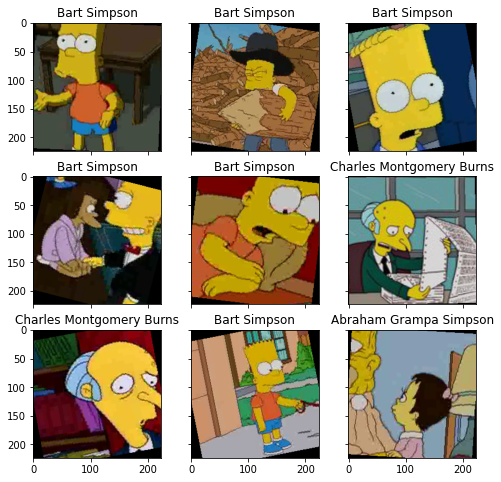

In [ ]:
# посмотрим картинки 

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### 3. Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
# функция для обучения
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

# функция для проверки 
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

# ОСНОВНОЙ ЦИКЛ
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_acc = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        opt = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9) # step_size=7 scheduler.step()
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            save_best_weight(model, val_acc)
    return history


# cохранение весов
def save_best_weight(model, val_acc)
  if best_acc == 0:  
    best_acc = val_acc
    torch.save(model.state_dict(), PATH_SAVE_WEIGHT) 
  elif val_acc > best_acc:
    torch.save(model.state_dict(), PATH_SAVE_WEIGHT) 

# функция предсказания вероятностей
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
torch.save(model.state_dict(), "./weights_resnet18") 

### 4. Инициализация сети

In [ ]:
# простая сеть
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [ ]:
# вторая сеть
n_classes = len(np.unique(train_val_labels))
model = models.vgg16(pretrained=True).to(DEVICE)
model.classifier[6] = nn.Linear(4096, n_classes).to(DEVICE)

layers_to_unfreeze = 2

# замораживаем параметры (веса)
for param in model.classifier[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
# третья cеть
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(DEVICE)
model.fc = nn.Linear(512, n_classes).to(DEVICE)

# замораживаем параметры (веса)
for param in model.parameters():
  param.requires_grad = False

for param2 in model.fc.parameters():
  param2.requires_grad = True  

for param3 in model.layer4[1].parameters():
  param3.requires_grad = True  
model

# # https://pytorch.org/hub/pytorch_vision_resnet/


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# list(model.parameters())

In [ ]:
# https://pytorch.org/hub/pytorch_vision_inception_v3/

### 5. Запустим обучение сети.

In [ ]:
epochs = 10
batch_size = 64
# lr = ??

# запускаем обучение
history = train(train_dataset, val_dataset, model=model, epochs=epochs, batch_size=batch_size)

# https://pytorch.org/hub/pytorch_vision_resnet/

100%|██████████| 246/246 [02:58<00:00,  1.38it/s]


loss 0.752677636234933



epoch:  10%|█         | 1/10 [03:59<35:56, 239.56s/it]


Epoch 001 train_loss: 0.7527     val_loss 0.4917 train_acc 0.8109 val_acc 0.8670



100%|██████████| 246/246 [03:05<00:00,  1.33it/s]


loss 0.45759877602957916



epoch:  20%|██        | 2/10 [08:03<32:16, 242.03s/it]


Epoch 002 train_loss: 0.4576     val_loss 0.5098 train_acc 0.8763 val_acc 0.8615



100%|██████████| 246/246 [03:01<00:00,  1.35it/s]


loss 0.32352594465266005



epoch:  30%|███       | 3/10 [12:05<28:15, 242.27s/it]


Epoch 003 train_loss: 0.3235     val_loss 0.4314 train_acc 0.9092 val_acc 0.8833



100%|██████████| 246/246 [02:59<00:00,  1.37it/s]


loss 0.23626448689035146



epoch:  40%|████      | 4/10 [16:04<24:04, 240.70s/it]


Epoch 004 train_loss: 0.2363     val_loss 0.3589 train_acc 0.9364 val_acc 0.9075



100%|██████████| 246/246 [03:03<00:00,  1.34it/s]


loss 0.18399912207944732



epoch:  50%|█████     | 5/10 [20:08<20:10, 242.07s/it]


Epoch 005 train_loss: 0.1840     val_loss 0.4216 train_acc 0.9497 val_acc 0.8961



100%|██████████| 246/246 [03:06<00:00,  1.32it/s]


loss 0.1595565541829795



epoch:  60%|██████    | 6/10 [24:17<16:17, 244.26s/it]


Epoch 006 train_loss: 0.1596     val_loss 0.3472 train_acc 0.9548 val_acc 0.9123



100%|██████████| 246/246 [03:09<00:00,  1.30it/s]


loss 0.12978747602962934



epoch:  70%|███████   | 7/10 [28:27<12:19, 246.33s/it]


Epoch 007 train_loss: 0.1298     val_loss 0.3713 train_acc 0.9627 val_acc 0.9047



100%|██████████| 246/246 [03:11<00:00,  1.28it/s]


loss 0.11812309891478943



epoch:  80%|████████  | 8/10 [32:40<08:17, 248.51s/it]


Epoch 008 train_loss: 0.1181     val_loss 0.4156 train_acc 0.9658 val_acc 0.9073



100%|██████████| 246/246 [03:10<00:00,  1.29it/s]


loss 0.10053085218833825



epoch:  90%|█████████ | 9/10 [36:55<04:10, 250.50s/it]


Epoch 009 train_loss: 0.1005     val_loss 0.3918 train_acc 0.9721 val_acc 0.9113



100%|██████████| 246/246 [03:19<00:00,  1.23it/s]


loss 0.09163221718832548



epoch: 100%|██████████| 10/10 [41:21<00:00, 248.14s/it]


Epoch 010 train_loss: 0.0916     val_loss 0.3640 train_acc 0.9721 val_acc 0.9152


### 6. Построим кривые обучения (лосс)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

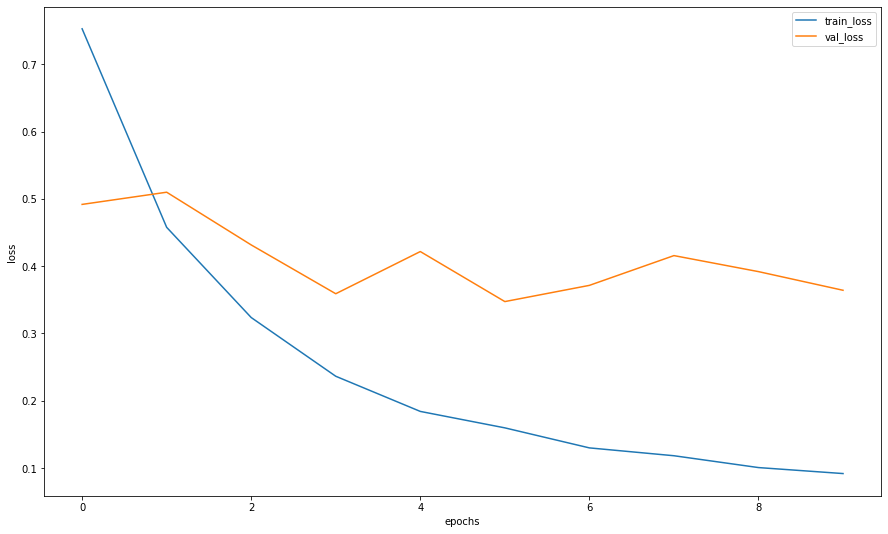

In [ ]:
# функция потерь по эпохам 

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

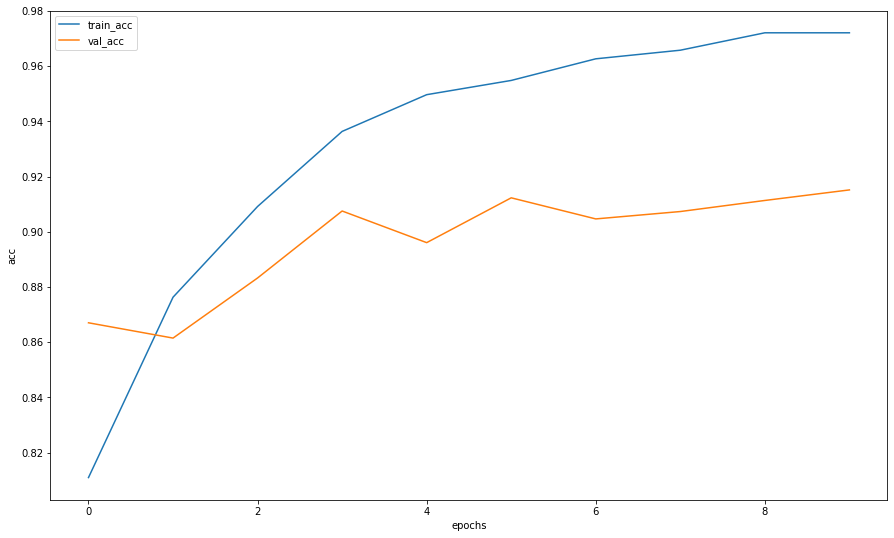

In [ ]:
# график точности по эпохам
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### 6. Считаем score
Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

random_characters, true_label, probs_im # cлучайный перс/ настоящая метка/ веоляьглсьт классов

(743,
 4,
 array([[8.48699347e-06, 1.78709161e-06, 3.44241721e-06, 2.88125104e-03,
         9.94722486e-01, 1.02227602e-07, 2.36506571e-06, 2.66475558e-06,
         3.73227607e-07, 2.47169737e-07, 2.70984546e-09, 3.55311244e-07,
         2.42023498e-06, 2.15961720e-08, 1.77225127e-06, 5.11345803e-04,
         2.25493804e-05, 3.80079618e-05, 3.44897266e-08, 5.32943943e-07,
         1.71237160e-04, 5.36440758e-08, 4.03975755e-05, 1.97607606e-05,
         3.54507210e-06, 8.22055972e-06, 5.07700634e-06, 4.28087787e-06,
         3.92321772e-06, 8.95414560e-04, 9.69390749e-05, 2.34821414e-06,
         3.92359725e-05, 1.35390965e-05, 3.95369425e-04, 3.67732573e-05,
         3.46872002e-05, 8.60655973e-07, 2.51653710e-05, 3.51467236e-07,
         4.55097933e-07, 2.18297282e-06]], dtype=float32))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)
# idxs, imgs[0].shape, probs_ims # несколько персов/ список картинок/ список вероятнсотей классов

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
#y_pred, actual_labels, preds_class  # класс с макс вероятностью/ реальыне метки классов / предсказаныне классы (названия)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
# метрика
f1_score(actual_labels, y_pred, average='micro')

0.9

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

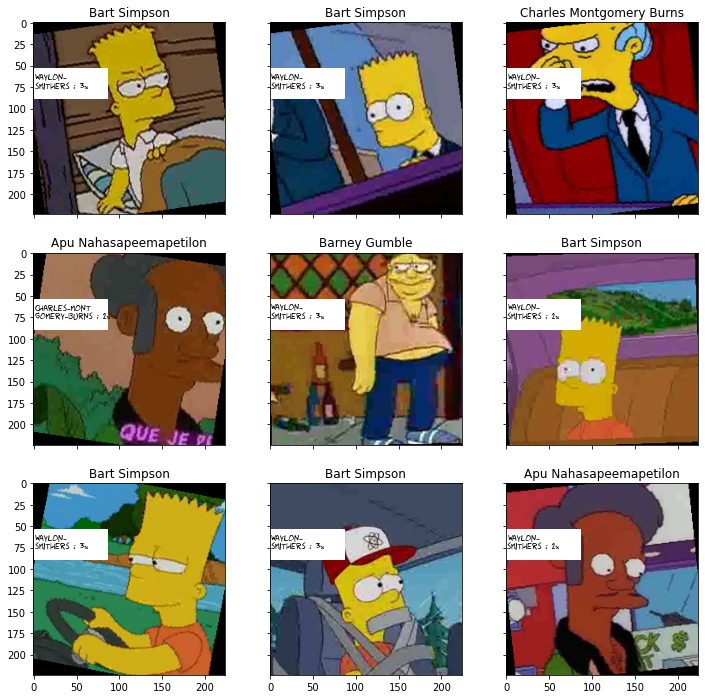

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  kaggle.json	sample_submission.csv
gdrive			     label_encoder.pkl	testset
journey-springfield.zip      sample_data	train


In [ ]:
import pandas as pd
# запись в файл
my_submit = pd.read_csv('./sample_submission.csv')
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [ ]:
my_submit["Expected"].describe()

count                  991
unique                  24
top       krusty_the_clown
freq                    58
Name: Expected, dtype: object

In [ ]:
my_submit.head(3)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders


In [ ]:
# my_submit.drop(columns="Image_id", inplace=True)

In [ ]:
# my_submit.head(3)

,Expected
0,nelson_muntz
1,bart_simpson
2,ned_flanders


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('./my_submit.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
